# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding,Dropout
from tensorflow.keras.optimizers import SGD


# Main Functions

In [2]:
def load_data(file):
    # Load  data from file and return it as panads dataframe
    return pd.read_csv(file)

def scale_features(X_train, X_test, scaler='standard'):
    # load x data and returned it as a scaled data
    if scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled        


In [3]:
# Dataset Ststics
def  data_stats(data,column):
    from nltk import FreqDist
    
    # Number of questions and ansers 
    print(f"Number of Questions are  {len(data)}")

    vocabulary_size = len(set(data[column].str.split().explode().dropna()))
    print(f"Number of Vocabulary Size = {vocabulary_size}")

    fdist = FreqDist(data[column].str.split().explode().dropna())
    most_frequent = fdist.most_common(10)  
    print(f"Most frequent words (top 10) = {most_frequent}")


# NLP Functions

In [4]:
# Drop Null Rows
def drop_null(train, test):
    train = train.dropna()
    test  = test.dropna().reset_index(drop=True)    
    return train, test

In [5]:
# Remove Non-Arabic Letters
def filter_arabic(text):
    import re
    arabic_pattern = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]+')
    arabic_text = arabic_pattern.findall(text)
    return ' '.join(arabic_text)

In [6]:
# Remove Dublicate Questions
def remove_duplicates_set(dataset):
  unique_questions = []
  seen_questions = {}
  for col in dataset:
    if col['question'] not in seen_questions:
      seen_questions[question] = True
    else:
      dataset.drop(axis=0,inplace=True)  
  return dataset

In [7]:
# Clean text using regular expression
def cleanText(text):
  import re
  text = re.sub(r'@|#\w+', '', text) # Remove hashtags or mentions
  text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # Substitute all URLs in the text with an empty string
  text = re.sub(r'(\?|!)+', '', text) # Remove question mark? And another one with an exclamation mark!
  text = re.sub(r'\d+', '', text) # Remove Numbers
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'^\s+', '', text) # Remove leading spaces
  text = re.sub(r'\s+$', '', text) # Remove trailing spaces
  return text

In [8]:
# Stop Words
from nltk.corpus import stopwords
nltk.download('stopwords')
arabic_stopwords = stopwords.words('arabic')

def remove_stop_words(text):
  return ' '.join([word for word in text.split() if word not in arabic_stopwords])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Normalizes Arabic letters in a text by replacing different forms of the latter (أ, آ, إ) to (ا) for example
import pyarabic.araby as araby
def normalize_arabic_letters(text):
    text = araby.strip_tashkeel(text)
    text = araby.strip_diacritics(text)
    text = araby.strip_shadda(text)
    text = araby.normalize_hamza(text,method="tasheel")
    return text

In [10]:
from nltk import word_tokenize
def count_arabic_words(data):
  df = pd.DataFrame({})
  def count_words(text):
    words = word_tokenize(text)  # Tokenize
    return len(words) 
   
  df['question'] = data['question']
  df['answer'] = data['answer']
  df['question_counter'] = data['question'].apply(count_words)
  df['answer_counter']   = data['answer'].apply(count_words)
  df['label']   = data['label']
  return df

# Model

## Load & Describe Data

In [24]:
train_data = load_data('train.csv')
test_data  = load_data('val.csv')

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87930 entries, 0 to 87929
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  87930 non-null  object
 1   answer    87756 non-null  object
 2   label     87930 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17586 entries, 0 to 17585
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  17586 non-null  object
 1   answer    17547 non-null  object
 2   label     17586 non-null  object
dtypes: object(3)
memory usage: 412.3+ KB


## PreProcessing DataSet

In [28]:
# 1.Drop Null Data From Train and Test Data   
train , test = drop_null(train_data, test_data)

In [29]:
train.head()

,question,answer,label
0,\nعندي الم مستمر داخل الشرج لا يوجد تشقق ولا ن...,\n\nاخي الكريم استخدم أقراص مضادة للالتهاب Pon...,General Surgery
1,\nهل يمكن لثوم ان يخفض من الضغظ وماهي الجرعه ا...,\n\nنعم يمكن وهناك كثير من الدراسات التي تؤكد ...,Blood diseases
2,\nعملت فحص سكر الصائم بعد صيام اكثر من ١٢ساعة\...,\n\nالنتيجة طبيعية\n2\n2023-06-03 08:16:44\n\n...,respiratory system diseases
3,\nعملت ماموجرام وموجات فوق صوتيه فوجدت تضخم فى...,\n\nيفضل طبعا عمل رنين لانه ادق بكثير لمعرفه ه...,Tumors
4,\nقبل ثلاثة أسابيع أصبت بالتهابات القصبات الهو...,\n\nالعودة والكشف عند الطبيب لمعرفة اثار المرض...,Blood diseases


In [30]:
train['label'].value_counts()


label
Tumors                         17478
General Surgery                17318
Endocrine diseases             15713
diabetes                       11883
Blood diseases                 10698
respiratory system diseases    10081
Orthopaedic Surgery             4585
Name: count, dtype: int64

In [31]:
# 2. Filtering Non-Arabic Content: Remove any irrelevant content that is not in Arabic
train.loc[:, 'question']  = train['question'].apply(filter_arabic)
train.loc[:, 'answer'  ]  = train['answer'].apply(filter_arabic)
test.loc[: , 'question']  = test['question'].apply(filter_arabic)
test.loc[: , 'answer'  ]  = test['answer'].apply(filter_arabic)

In [32]:
# 3. Remove duplicated questions  from dataset 
train_unique_data = train.drop_duplicates(subset=['question'])
test_unique_data  = test.drop_duplicates(subset=['question'])

print("train_unique_dataset : ",len(train_unique_data)) 
print("train_question",len(train)) 

print("test_unique_dataset : ",len(test_unique_data)) 
print("test_question",len(test)) 


train_unique_dataset :  52468
train_question 87756
test_unique_dataset :  10594
test_question 17547


In [33]:
# 4 Clean Text from sprecail cahr and so on
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(cleanText)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(cleanText)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(cleanText)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(cleanText)

In [34]:
# 5. Remove Arabic Stop Words 
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(remove_stop_words)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(remove_stop_words)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(remove_stop_words)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(remove_stop_words)

In [35]:
# 6 Normalize arabic letters
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(normalize_arabic_letters)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(normalize_arabic_letters)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(normalize_arabic_letters)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(normalize_arabic_letters)

In [36]:
print("Train Data states (Questions) : ")
data_stats(train_unique_data,'question')
print("---------------------------------------------")
print("Train Data states (Answers) : ")
data_stats(train_unique_data,'answer')
print("=========================================================================")
print("Test Data states (Questions) : ")
data_stats(test_unique_data,'question')
print("---------------------------------------------")
print("Test Data states (Answers) : ")
data_stats(test_unique_data,'answer')

Train Data states (Questions) : 
Number of Questions are  52468
Number of Vocabulary Size = 74974
Most frequent words (top 10) = [('انا', 9366), ('ان', 8124), ('اعاني', 7140), ('عليكم', 7014), ('السلام', 6545), ('عندي', 6115), ('او', 5844), ('الدم', 5008), ('الم', 4969), ('علاج', 4549)]
---------------------------------------------
Train Data states (Answers) : 
Number of Questions are  52468
Number of Vocabulary Size = 79719
Most frequent words (top 10) = [('الدكتور', 71201), ('طبية', 52785), ('اسيلة', 52504), ('جراحة', 32276), ('الدم', 24269), ('امراض', 24088), ('الغدد', 19652), ('الصماء', 18007), ('محمد', 17077), ('علي', 13829)]
Test Data states (Questions) : 
Number of Questions are  10594
Number of Vocabulary Size = 28900
Most frequent words (top 10) = [('انا', 1868), ('ان', 1634), ('عليكم', 1433), ('اعاني', 1396), ('السلام', 1306), ('عندي', 1220), ('او', 1173), ('الم', 1057), ('الدم', 1023), ('علاج', 912)]
---------------------------------------------
Test Data states (Answers) :

In [37]:
# 7. Reformate data frame
new_train_data = count_arabic_words(train_unique_data)
new_test_data = count_arabic_words(test_unique_data)
new_test_data.head()

,question,answer,question_counter,answer_counter,label
0,هى الاعراض الاولى لمرض السكر,اعراض مرض السكر كثيره اهمها العطش كثرة ادرار ا...,5,37,جراحة عامة
1,يمكن علاج الناسور العصعصي بدون جراحة,علاج الناسور العصعصي يكون بالجراحة فقط الدكتور...,6,22,جراحة_العظام
2,ماهي الاثار الجانبية لستيصال الغده الدرقيه الع...,تغييرات عديدة العمليات الحيوية لمواد عديدة الج...,16,43,ارتفاع_ضغط_الدم
3,نقص بهرمون الذكورة ووصف الدكتور حقت سيدوتسترون...,يجب اتباع التعليمات الطبية عدم وقف العلاج تستم...,22,32,امراض-الغدد-الصماء
4,عملت عملية دوالي الساقين قسطرة الليزر شهر احس ...,مرحبا العملية يمكن يحدث الاعراض المشابهة لتلك ...,26,91,أمراض الجهاز التنفسي


## Building Model

In [38]:
tag = []
patterns = []
responses = []
for index, row in new_train_data.iterrows():    
    for column in new_train_data.columns:  
        responses.append(row['answer'])
        patterns.append(row['question'])
        tag.append(row['label'])


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(patterns)
y = np.array(tag)

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [64]:
tokenizer = Tokenizer(num_words=1000, oov_token="<UNK>")
tokenizer.fit_on_texts(patterns)

In [65]:
sequences = tokenizer.texts_to_sequences(patterns)

In [66]:
final_sequences = pad_sequences(sequences,maxlen=50,truncating='post')

In [67]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tags = le.fit_transform(tag)
labels = to_categorical(tags)

In [68]:
final_sequences.shape

(262340, 50)

In [60]:
len(set(tag))

7

In [69]:
import tensorflow as tf

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(7,)),      
    tf.keras.layers.Embedding(1000,7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.LSTM(128, return_sequences=True),            
    tf.keras.layers.LSTM(64),            
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7,activation='softmax') 
])


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 7, 7)           │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7, 128)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,471 (740.12 KB)

 Trainable params: 189,471 (740.12 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(final_sequences,labels,epochs=50,batch_size=128,validation_data=(final_sequences,labels),verbose=1
)

Epoch 1/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 498s 243ms/step - accuracy: 0.6034 - loss: 1.2619 - val_accuracy: 0.6167 - val_loss: 1.2184
Epoch 2/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 487s 237ms/step - accuracy: 0.6111 - loss: 1.2399 - val_accuracy: 0.6217 - val_loss: 1.2043
Epoch 3/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 648s 316ms/step - accuracy: 0.6185 - loss: 1.2172 - val_accuracy: 0.6282 - val_loss: 1.1809
Epoch 4/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 609s 297ms/step - accuracy: 0.6225 - loss: 1.2008 - val_accuracy: 0.6388 - val_loss: 1.1438
Epoch 5/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 613s 299ms/step - accuracy: 0.6315 - loss: 1.1729 - val_accuracy: 0.6511 - val_loss: 1.1024
Epoch 6/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 580s 283ms/step - accuracy: 0.6410 - loss: 1.1351 - val_accuracy: 0.6658 - val_loss: 1.0448
Epoch 7/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 521s 254ms/step - accuracy: 0.6506 - loss: 1.0901 - val_accuracy: 0.6809 - val_loss: 0.9844
Epoch 8/50
2050/2050 ━━━━━━━━━━━━━━━━━━━━ 524s 256ms/step - ac

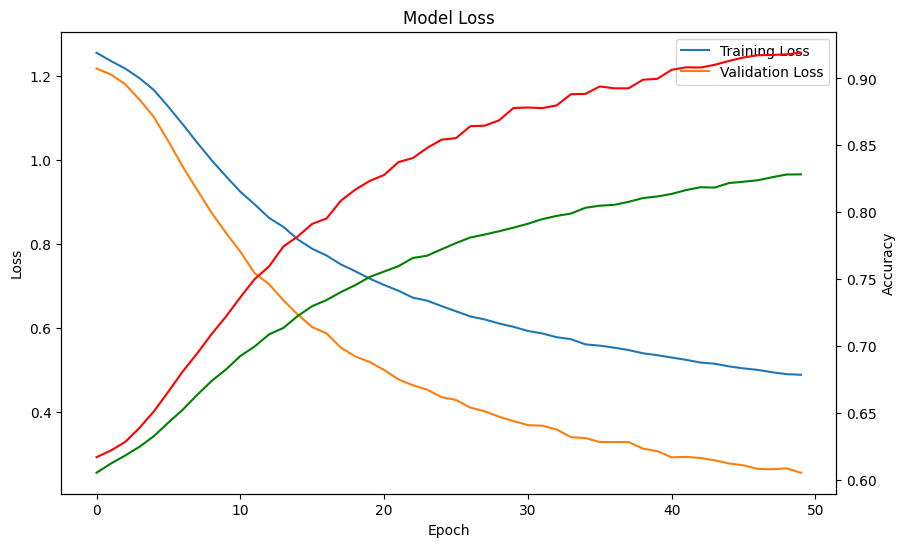

In [74]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation accuracy (if applicable)
train_acc = history.history['accuracy']  # Modify key based on your metric
val_acc = history.history['val_accuracy']  # Modify key based on your metric

# Create the plot
plt.figure(figsize=(10, 6))

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot accuracy (if applicable)
plt.twinx()  # Create a second y-axis for accuracy
plt.plot(train_acc, 'g-', label='Training Accuracy')
plt.plot(val_acc, 'r-', label='Validation Accuracy')
plt.ylabel('Accuracy')

plt.show()

In [75]:
test = 'علاج ارتفاغ السكر التراكمي'
test = tokenizer.texts_to_sequences([test])
test2 = pad_sequences(test,maxlen=20)
result = model.predict(test2)
output_class = np.argmax(result)
le.inverse_transform(np.array([output_class]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array(['diabetes'], dtype='<U27')

In [125]:
model.save('chatbotClassificationModel.keras')

In [124]:
import pickle
pickle.dump(tokenizer,open('chatbotTokinizer.pkl','wb'))
pickle.dump(le,open('chatbotLabelencoder.pkl','wb'))